# Mutlvariate Optimization, Interpolation, and Differentiation


In [1]:
import math
import numpy as np
import scipy

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image

## Multivariate optimization

Multivariate optimization is more difficult than univariate optimization 
* The coordinate ($x$) is now a vector --- $x_i, i=0,\ldots,n-1$
* The first derivative or gradient ($g$) is now a vector --- $g_i = \frac{df}{dx_i}$
* The second derivative or hessian ($H$) is now a matrix --- $h_{ij}= \frac{d^2f}{dx_i^2}$
* There are so many more directions in which to move 
* There are more types of stationary points

At a conceptual level, multivariate optimization still involves primarily the gradient (first derivative) and Hessian (second derivative) of a function.
* At a stationary point the (vector) gradient of the function should be zero
* At a minimum all of the eigenvalues of the Hessian should be positive
* At a maximum all of the eigenvalues of the Hessian should be negative

In [2]:
import sympy
x1, x2 = sympy.symbols("x_1, x_2")

In [3]:
f_sym = (x1-1)**4 + 5 * (x2-1)**2 - 2*x1*x2; f_sym

-2*x_1*x_2 + (x_1 - 1)**4 + 5*(x_2 - 1)**2

In [4]:
fprime_sym = [f_sym.diff(x1), f_sym.diff(x2)]; fprime_sym

[-2*x_2 + 4*(x_1 - 1)**3, -2*x_1 + 10*x_2 - 10]

In [5]:
# Gradient
fprime_sym = [f_sym.diff(x_) for x_ in (x1, x2)]; sympy.Matrix(fprime_sym)

Matrix([
[-2*x_2 + 4*(x_1 - 1)**3],
[   -2*x_1 + 10*x_2 - 10]])

In [6]:
sols = sympy.solve(fprime_sym); sols[0]

{x_1: 30**(1/3)*(sqrt(72870)/30 + 9 + (1 + (30*sqrt(72870) + 8100)**(1/3))*(30*sqrt(72870) + 8100)**(1/3)/30)/(sqrt(72870) + 270)**(2/3),
 x_2: 1/(750*(sqrt(72870)/112500 + 3/1250)**(1/3)) + (sqrt(72870)/112500 + 3/1250)**(1/3) + 6/5}

In [7]:
X_opt = [sols[0][x1].evalf(), sols[0][x2].evalf()]
X_opt

[1.88292612929632, 1.37658522585926]

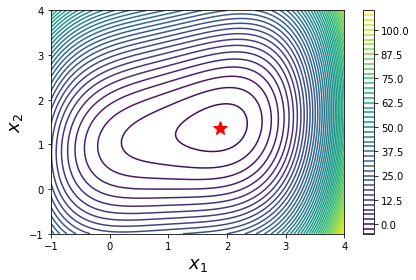

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# plot the contour of the function
f_lmbda = sympy.lambdify((x1, x2), f_sym, 'numpy')

fig, ax = plt.subplots(figsize=(6, 4))
x_ = y_ = np.linspace(-1, 4, 100)
X, Y = np.meshgrid(x_, y_)
c = ax.contour(X, Y, f_lmbda(X, Y), 50)
ax.plot(X_opt[0], X_opt[1], 'r*', markersize=15)
ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)
plt.colorbar(c, ax=ax)
fig.tight_layout()

At the minimum, the eigenvalues of the Hessian matrix should be positive.

In [9]:
# Hessian
fhess_sym = [[f_sym.diff(x1_, x2_) for x1_ in (x1, x2)] for x2_ in (x1, x2)]; sympy.Matrix(fhess_sym)

Matrix([
[12*(x_1 - 1)**2, -2],
[             -2, 10]])

In [10]:
H = np.array([[fhess_sym[0][0].subs({x1:X_opt[0], x2:X_opt[1]}), 
               fhess_sym[1][0].subs({x1:X_opt[0], x2:X_opt[1]})],
              [fhess_sym[0][1].subs({x1:X_opt[0], x2:X_opt[1]}), 
               fhess_sym[1][1].subs({x1:X_opt[0], x2:X_opt[1]})]], 
             dtype=float); H

array([[ 9.3547026, -2.       ],
       [-2.       , 10.       ]])

In [11]:
np.linalg.eigvals(H)

array([ 7.65149292, 11.70320968])

### Numerical Solution

The `optimize` package provides a few functions to for multivariate minimization.


`fmin` uses the downhill simplex algorithm, which is gradient free (i.e., it does not require derivatives).

In [12]:
def func_XY_to_X_Y(f):
    """
    Wrapper for f(X) -> f(X[0], X[1])
    """
    return lambda X: np.array(f(X[0], X[1]))

f_lmbda = sympy.lambdify((x1, x2), f_sym, 'numpy')
f = func_XY_to_X_Y(f_lmbda)

In [13]:
import scipy.optimize as optimize
optimize.fmin(f, (0,0))

Optimization terminated successfully.
         Current function value: -3.867223
         Iterations: 68
         Function evaluations: 128


array([1.88296217, 1.37657705])

Newton's method requires the Hessian matrix which it can estimate numerically from the gradient. This is offered as `fmin_ncg`, which stands for Newton-CG method.

In [14]:
fprime_lmbda = sympy.lambdify((x1, x2), fprime_sym, 'numpy')
fhess_lmbda = sympy.lambdify((x1, x2), fhess_sym, 'numpy')

fprime = func_XY_to_X_Y(fprime_lmbda)
fhess = func_XY_to_X_Y(fhess_lmbda)

In [15]:
optimize.fmin_ncg(f, (0,0), fprime=fprime, fhess=fhess)

Optimization terminated successfully.
         Current function value: -3.867223
         Iterations: 8
         Function evaluations: 10
         Gradient evaluations: 10
         Hessian evaluations: 8


array([1.88292613, 1.37658523])

We could also use the `fmin_bfgs` or `fmin_cg` methods, which can take advantage of the gradient vectors but don't need the Hessian.

In [16]:
optimize.fmin_bfgs(f, (0,0), fprime=fprime)

Optimization terminated successfully.
         Current function value: -3.867223
         Iterations: 9
         Function evaluations: 13
         Gradient evaluations: 13


array([1.88292645, 1.37658596])

In [17]:
optimize.fmin_cg(f, (0,0), fprime=fprime)

Optimization terminated successfully.
         Current function value: -3.867223
         Iterations: 8
         Function evaluations: 18
         Gradient evaluations: 18


array([1.88292612, 1.37658523])

## Looking for the global minimum

All of the methods we have seen so far will only converge to a "nearby" minimum that may just be a local minimum instead of the lowest possible.
* In general, finding the global minimum is very hard.

There are some intelligent approaches (e.g., simulated annealing, evolutionary algorithms, etc.) but they are complicated and typically need to be specialized to the actual problem --- i.e., there aren't many black box functions to use and those that exist may be slow.

One approach is to brute-force search for initial point

Consider this function with many local minima.  This example might correspond to 
* interaction energy of an atom moving on the surface of a bumpy material, or 
* a pebble rolling on a rocky beach, or ...

In [18]:
for x_start in [(-2,-2),(4,4),(4,-3)]:
    x_opt = optimize.fmin_bfgs(f, x_start, disp=False)
    print(x_start,"-->", x_opt, f(x_opt))

(-2, -2) --> [1.8829261  1.37658521] -3.8672228877127917
(4, 4) --> [1.88292613 1.37658522] -3.8672228877127957
(4, -3) --> [1.88292616 1.37658523] -3.8672228877127903


One brute force approach is to use a uniform mesh of starting points and optimize from each one, keeping the lowest.

In [19]:
xy = np.zeros(2)
fxy= f(xy)
for x in np.linspace(-3,5,9):
    for y in np.linspace(-3,5,9):
        x_opt = optimize.fmin_bfgs(f, np.array([x,y]),disp=False)
        f_opt = f(x_opt)
        #print((x,y),"-->", x_opt, f_opt)
        if f_opt<fxy:
            xy, fxy = x_opt, f_opt
print("The lowest point found", xy, fxy)

The lowest point found [1.88292613 1.37658522] -3.8672228877127965


Scipy provides `optimize.brute` that searches on a uniform mesh for the lowest point, with an option of optimzing from that final point.

In [20]:
x_start = optimize.brute(f, (slice(-3, 5, 0.5), slice(-3, 5, 0.5)), finish=None); x_start

array([2. , 1.5])

In [21]:
x_opt = optimize.fmin_bfgs(f, x_start); x_opt

Optimization terminated successfully.
         Current function value: -3.867223
         Iterations: 5
         Function evaluations: 24
         Gradient evaluations: 8


array([1.88292611, 1.37658522])

## Interpolation

Interpolation is the process of defining a function that takes on specified values at specified points. The result function can be useful for table lookup, plotting, numerical differentiation, numerical integration, etc.

The commonly used interpolations include polynomial, piecewise polynomial (such as splines), trignometric, etc. We have seen polynomial interpolation in earlier lectures. 

In `scipy`, interpolation is simple and convenient. For 1-D problems, the `interp1d` function, when given arrays describing X and Y data, returns an object that behaves like a function that can be called for an arbitrary value of x (in the range covered by X), and it returns the corresponding interpolated y value:

In [22]:
import scipy.interpolate as interpolate

In [23]:
interpolate.interp1d?

In [24]:
def f(x):
    return np.sin(x)

In [25]:
x = np.arange(0, 10)  
y = f(x) + 0.1*np.random.randn(10)

# Construct interpolation operator using piecewise linear interpolation
linear_interpolation = interpolate.interp1d(x, y, kind='linear')

x_samples = np.linspace(0, 9, 100)
y_interp1 = linear_interpolation(x_samples)

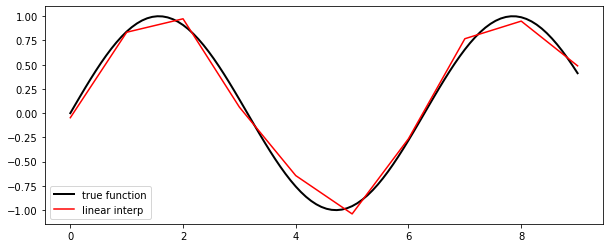

In [26]:
y_real = f(x_samples)

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(x_samples, y_real, 'k', lw=2, label='true function')
ax.plot(x_samples, y_interp1, 'r', label='linear interp')
ax.legend(loc=3);

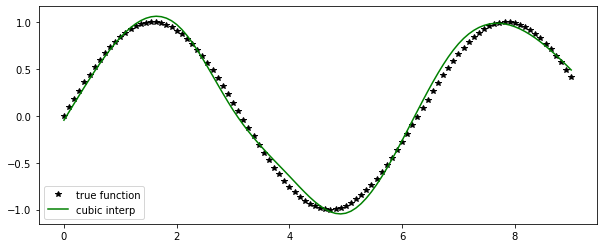

In [27]:
# Construct interpolation operator using piecewise cubic interpolation (cubic splines)
cubic_interpolation = interpolate.interp1d(x, y, kind='cubic')
y_interp2 = cubic_interpolation(x_samples)

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(x_samples, y_real, '*k', lw=2, label='true function')
ax.plot(x_samples, y_interp2, 'g', label='cubic interp')
ax.legend(loc=3);

### Multivariate interpolation

Besides interpolation of scalar functions, we can also perform multivariate interpolation in `scipy`.

### Regular grid

On regular grids in 2-D, we can use the function `interp2d`, which behave similarly to `interp1d`.

In [28]:
interpolate.interp2d?

In [29]:
x = y = np.linspace(-2, 2, 10)

def f(x, y):
    return np.exp(-(x + .5)**2 - 2*(y + .5)**2) - np.exp(-(x - .5)**2 - 2*(y - .5)**2)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)

In [30]:
f_interp = interpolate.interp2d(x, y, Z, kind='cubic')

In [31]:
xx = yy = np.linspace(x.min(), x.max(), 100)
ZZi = f_interp(xx, yy)

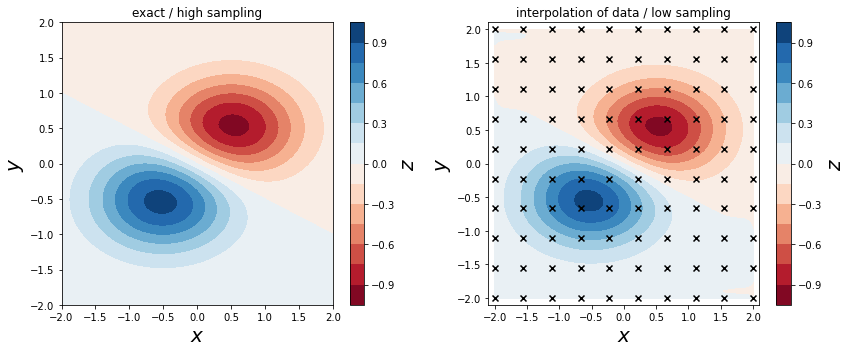

In [32]:
# Plot contours of results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

XX, YY = np.meshgrid(xx, yy)
c = axes[0].contourf(XX, YY, f(XX, YY), 15, cmap=plt.cm.RdBu)
axes[0].set_xlabel(r"$x$", fontsize=20)
axes[0].set_ylabel(r"$y$", fontsize=20)
axes[0].set_title("exact / high sampling")
cb = fig.colorbar(c, ax=axes[0])
cb.set_label(r"$z$", fontsize=20)

c = axes[1].contourf(XX, YY, ZZi, 15, cmap=plt.cm.RdBu)
axes[1].set_ylim(-2.1, 2.1)
axes[1].set_xlim(-2.1, 2.1)
axes[1].set_xlabel(r"$x$", fontsize=20)
axes[1].set_ylabel(r"$y$", fontsize=20)
axes[1].scatter(X, Y, marker='x', color='k')
axes[1].set_title("interpolation of data / low sampling")
cb = fig.colorbar(c, ax=axes[1])
cb.set_label(r"$z$", fontsize=20)

fig.tight_layout()

### Irregular grid

We can also interpolate scattered date using the `griddata` function.

In [ ]:
interpolate.griddata?

In [ ]:
np.random.seed(115925231)
N = 500
xdata = np.random.uniform(-1, 1, N)
ydata = np.random.uniform(-1, 1, N)

zdata = f(xdata, ydata)

In [ ]:
def z_interpolate(xdata, ydata, zdata, X, Y):
    Zi_0 = interpolate.griddata((xdata, ydata), zdata, (X, Y), method='nearest')
    Zi_1 = interpolate.griddata((xdata, ydata), zdata, (X, Y), method='linear')
    Zi_3 = interpolate.griddata((xdata, ydata), zdata, (X, Y), method='cubic')
    return Zi_0, Zi_1, Zi_3

In [ ]:
x = y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)

Zi_0, Zi_1, Zi_3 = z_interpolate(xdata, ydata, zdata, X, Y)

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=True)

n_vec = [50, 150, 500]

for idx, n in enumerate(n_vec):
    Zi_0, Zi_1, Zi_3 = z_interpolate(xdata[:n], ydata[:n], zdata[:n], X, Y)
    axes[idx, 0].contourf(X, Y, Zi_0, 15, cmap=plt.cm.RdBu)
    axes[idx, 0].scatter(xdata[:n], ydata[:n], marker='.')
    axes[idx, 0].set_ylabel("%d data points\ny" % n, fontsize=16)
    axes[idx, 0].set_title("nearest", fontsize=16)
    axes[idx, 1].contourf(X, Y, Zi_1, 15, cmap=plt.cm.RdBu)
    axes[idx, 1].set_title("linear", fontsize=16)
    axes[idx, 1].scatter(xdata[:n], ydata[:n], marker='.')
    axes[idx, 2].contourf(X, Y, Zi_3, 15, cmap=plt.cm.RdBu)
    axes[idx, 2].set_title("cubic", fontsize=16)
    axes[idx, 2].scatter(xdata[:n], ydata[:n], marker='.')

for m in range(len(n_vec)):
    axes[idx, m].set_xlabel("x", fontsize=16)
    
fig.tight_layout()

## Integration

### Numerical integration: quadrature

Numerical evaluation of a function of the type

$$\displaystyle \int_a^b f(x) dx$$

is called *numerical quadrature*, or simply *quadature*. SciPy provides a series of functions for different kind of quadrature, for example the `quad`, `dblquad` and `tplquad` for single, double and triple integrals, respectively.

Integration can be interpreted in many different ways.  The most straightforward is the area under a curve.

In [ ]:
# Adapted from https://matplotlib.org/3.1.1/gallery/showcase/integral.html
from matplotlib.patches import Polygon

def f(x):
    return (x - 3) * (x - 5) * (x - 7) + 85

a, b = 2, 9  # integral limits
x = np.linspace(0, 10)
y = f(x)

fig, ax = plt.subplots()
ax.plot(x, y, 'r', linewidth=2)
ax.set_ylim(bottom=0)

ix = np.linspace(a, b)
iy = f(ix)
verts = [(a, 0), *zip(ix, iy), (b, 0)]
poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
ax.add_patch(poly)

ax.text(0.5 * (a + b), 30, r"$\int_a^b f(x)\mathrm{d}x$",
        horizontalalignment='center', fontsize=20)

fig.text(0.9, 0.05, '$x$')
fig.text(0.1, 0.9, '$y$')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')

ax.set_xticks((a, b))
ax.set_xticklabels(('$a$', '$b$'))
ax.set_yticks([])

plt.show()

The simplist numerical approximation is to divide the region into boxes and add up the areas of each box

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, y, 'r', linewidth=2)
ax.set_ylim(bottom=0)
poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
ax.add_patch(poly)

fig.text(0.9, 0.05, '$x$')
fig.text(0.1, 0.9, '$y$')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')

ax.set_xticks((a, b))
ax.set_xticklabels(('$a$', '$b$'))
ax.set_yticks([])

npt = 4
xx = np.linspace(a, b, npt)
yy = f(xx)
for i in range(1,npt):
    ax.annotate("",
                xy=(xx[i-1],yy[i-1]), xycoords='data',
                xytext=(xx[i],yy[i]), textcoords='data',
                arrowprops=dict(arrowstyle="-",
                connectionstyle="arc3,rad=0."))
    ax.annotate("",
                xy=(xx[i],yy[i]), xycoords='data',
                xytext=(xx[i],0), textcoords='data',
                arrowprops=dict(arrowstyle="-",
                connectionstyle="arc3,rad=0."))

In [ ]:
# exact answer is 624.75 ... adjust NPT in the above cell to get more accuracy 
area = 0.0
for i in range(1,npt):
    area += 0.5*(yy[i-1]+yy[i])*(xx[i]-xx[i-1]) # area of each trapezoid
print(area)


SymPy can evaluate some integrals

In [ ]:
import sympy
X = sympy.symbols("X")
print(sympy.integrate((X - 3) * (X - 5) * (X - 7) + 85, X))
print(sympy.integrate((X - 3) * (X - 5) * (X - 7) + 85, (X,2.0,9.0)))


Integration can also be regarded as
* The inverse of differentiation (i.e., antiderivative)
* The limit of discrete sum as you get many values in the sum

While the above trapezoid rule for integration is great to understand how things work (and in some settings can be very useful) there are many more powerful techniques for numerical integration.

In [ ]:
import scipy.integrate as integrate

The `quad` function takes a large number of optional arguments, which can be used to fine-tune the behaviour of the function.

In [ ]:
integrate.quad?

The basic usage is as follows:

In [ ]:
# define a simple function for the integrand
def f(x):
    return x

In [ ]:
x_lower = 0 # the lower limit of x
x_upper = 1 # the upper limit of x

val, abserr = integrate.quad(f, x_lower, x_upper)

print("integral value =", val, ", absolute error =", abserr)

If we need to pass extra arguments to integrand function we can use the `args` keyword argument:

In [ ]:
def integrand(x, n):
    """
    Bessel function of first kind and order n. 
    """
    return scipy.special.jn(n, x)


x_lower = 0  # the lower limit of x
x_upper = 10 # the upper limit of x

val, abserr = integrate.quad(integrand, x_lower, x_upper, args=(3,))

print(val, abserr)

For simple functions we can use a lambda function (anonymous function) instead of explicitly defining a function for the integrand:

In [ ]:
val, abserr = integrate.quad(lambda x: np.exp(-x ** 2), -np.Inf, np.Inf)

print("numerical  =", val, abserr)

analytical = np.sqrt(np.pi)
print("analytical =", analytical)

As show in the example above, we can also use 'Inf' or '-Inf' as integral limits.

**Example:**  We are told that the probability that someone's is height $h\ge0$ (in feet) is given by the function $\rho(h)$ (see below).  Your organization only hires people who are taller than 4 feet and shorter than 6.5 feet.  

What is the average height of the people you are hiring?  I.e., evaluate this ratio.
$$
<h> = \frac{\int_4^{6.5} h \rho(h) dh}{\int_4^{6.5} \rho(h) dh}
$$
\[The integral on the bottom is the fraction of the entire population that have height in the required range. \]

In [ ]:
def rho(h):
    return h*exp(-(h-5)**2)

Higher-dimensional integration works in a similar way:

In [ ]:
integrate.dblquad?

In [ ]:
def integrand(y, x):
    return np.exp(-x ** 2 - y ** 2)

x_lower = 0  
x_upper = 10
y_lower = 0
y_upper = 10

val, abserr = integrate.dblquad(integrand, x_lower, x_upper, lambda x : y_lower, lambda x: y_upper)

print(val, abserr)

Note how we had to pass lambda functions for the limits for the y integration, since these in general can be functions of x.

## Further reading
* Chapter 6 of Numerical Python book on optimization
* Interpolation: Chapter 7 of Numerical Python book
* Integration: Chapter 8 of Numerical Python book

## Acknowledgements

Adapted from J.R. Johansson's Scientific Python Lectures available at [http://github.com/jrjohansson/scientific-python-lectures](http://github.com/jrjohansson/scientific-python-lectures).